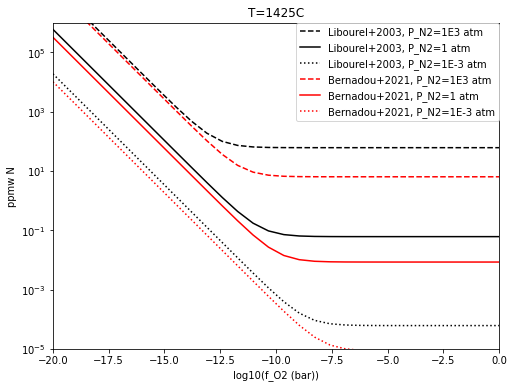

In [11]:
import numpy as np
import matplotlib.pyplot as plt

########
###CONSTANTS
########
bar2atm=0.9869 #1 bar in atm
atm2bar=1.0/bar2atm
bar2GPa = 1.0E-4 #1 bar in gigaPascals
GPa2bar = 1.0E+4 #1 gigaPascal in bar

R_J_mol=8.3144621 #Universal gas constant in units of J K**-1 mol**-1

mu_N=14.01 #grams/mol
mu_magma=62.52 #grams/mol

##########
###Libourel et al. 2003 N solubility law
##########

def x_N_m_libourel_2003(f_N2_bar, f_O2_bar):
    """
    Takes: 
        --nitrogen fugacity, bar
        --oxygen fugacity, bar
        
    Returns:
        mol fraction nitrogen in melt, as N
        
    The law in Libourel et al is presented as being in pN2. However, they also take gamma=1 (i.e. partial pressure=fugacity) in this paper in their pressure range. I think formally fugacity is more correct, so I will use this instead.
    
    Their formalism reports ppm N. I assume this is mass fraction in ppm of N in the melt. I convert it to mol fraction of N
    
    They do not specify units in equation 23, but based on context I infer it to be in atm. Therefore, a unit conversion is necesary. 
    """
    f_O2_atm=f_O2_bar*bar2atm
    f_N2_atm=f_N2_bar*bar2atm
    
    w_N_m_ppmw=0.0611*f_N2_atm + (5.97E-10)*(f_O2_atm**(-0.75))*(f_N2_atm**0.5)
    
    w_N_m=w_N_m_ppmw*1.0E-6
    
    x_N_m=w_N_m*mu_magma/mu_N
    
    return x_N_m

##########
###Bernadou et al. 2021 N solubility law, two versions (depending on what the units of Equation 18 are)
##########

def x_N_m_bernadou_2021(f_N2_bar, f_O2_bar, T_K, P_bar):
    """
    Takes: 
        --nitrogen fugacity, bar
        --oxygen fugacity, bar
        
    Returns:
        mol fraction nitrogen in melt, as N
            
    UPDATE: Bernadou in an email dated 8/16/2021 gives the units to be mol N/100g melt. 
    """
    
    deltaH_13=29344. #J/mol
    deltaS_13=-121. #J*K/mol
    deltaV_13=4. #J/bar
    deltaV_13_prime=-0.00019 #Units: J/bar^2???
    
    deltaH_14=183733. #J/mol
    deltaS_14=-172. #J*K/mol
    deltaV_14=-5. #J/bar
    deltaV_14_prime=0.0004 #Units: J/bar^2???
    
    ###delta-V correction:
    if np.isscalar(P_bar): #If P is a scalar, 
        if P_bar<1.0*bar2GPa: #update the deltaVs if needed.
            deltaV_13_adjusted=deltaV_13+deltaV_13_prime*P_bar
            deltaV_14_adjusted=deltaV_14+deltaV_14_prime*P_bar
            
            deltaG_13=deltaH_13-T_K*deltaS_13+P_bar*deltaV_13_adjusted
            deltaG_14=deltaH_14-T_K*deltaS_14+P_bar*deltaV_14_adjusted
        else: #if not needed, do not adjusted the delta Vs.
            deltaG_13=deltaH_13-T_K*deltaS_13+P_bar*deltaV_13
            deltaG_14=deltaH_14-T_K*deltaS_14+P_bar*deltaV_14
    else: #if P_bar is an array, must change the deltaVs for each P_bar.
        #initialize
        deltaV_13_adjusted=np.ones(np.shape(P_bar))*deltaV_13
        deltaV_14_adjusted=np.ones(np.shape(P_bar))*deltaV_14
        #adjust
        deltaV_13_adjusted[P_bar<1.0*bar2GPa]=+ P_bar[P_bar<1.0*bar2GPa]*deltaV_13_prime
        deltaV_14_adjusted[P_bar<1.0*bar2GPa]=+ P_bar[P_bar<1.0*bar2GPa]*deltaV_14_prime
        #Calculate
        deltaG_13=deltaH_13-T_K*deltaS_13+P_bar*deltaV_13_adjusted
        deltaG_14=deltaH_14-T_K*deltaS_14+P_bar*deltaV_14_adjusted
   
    
    K_13=np.exp((-deltaG_13)/(R_J_mol*T_K))
    K_14=np.exp((-deltaG_14)/(R_J_mol*T_K))

    
    conc_N_m=K_13*f_N2_bar + K_14*(f_O2_bar**(-0.75))*(f_N2_bar**0.5) #units: mol of N per 100 g of melt, according to Bernadou pers. comm.    
    x_N_m=conc_N_m*0.01*mu_magma #mol fraction N
    
    return x_N_m


######
###Plot, compare Libourel+2003 and Bernadou+2021
######
####################
###N2 Solubility
####################
#Approximate Figure 7 of Libourel+2003
f_O2_atm_list=np.logspace(-20.0, 0, num=30)
f_O2_bar_list=f_O2_atm_list*atm2bar
    
fig, ax=plt.subplots(1, figsize=(8., 6.))
ax.set_title('T=1425C')
ax.plot(np.log10(f_O2_bar_list), x_N_m_libourel_2003(1.0E3*atm2bar, f_O2_bar_list)*mu_N/mu_magma*1E6, color='black', linestyle='--', label='Libourel+2003, P_N2=1E3 atm')
ax.plot(np.log10(f_O2_bar_list), x_N_m_libourel_2003(1.0*atm2bar, f_O2_bar_list)*mu_N/mu_magma*1E6, color='black', linestyle='-', label='Libourel+2003, P_N2=1 atm')
ax.plot(np.log10(f_O2_bar_list), x_N_m_libourel_2003(1.0E-3*atm2bar, f_O2_bar_list)*mu_N/mu_magma*1E6, color='black', linestyle=':', label='Libourel+2003, P_N2=1E-3 atm')
    
ax.plot(np.log10(f_O2_bar_list), x_N_m_bernadou_2021(1.0E3*atm2bar, f_O2_bar_list, 1425+273., 1.0E3*atm2bar+f_O2_bar_list)*mu_N/mu_magma*1E6, color='red', linestyle='--', label='Bernadou+2021, P_N2=1E3 atm')
ax.plot(np.log10(f_O2_bar_list), x_N_m_bernadou_2021(1.0*atm2bar, f_O2_bar_list, 1425+273., 1.0*atm2bar+f_O2_bar_list)*mu_N/mu_magma*1E6, color='red', linestyle='-', label='Bernadou+2021, P_N2=1 atm')
ax.plot(np.log10(f_O2_bar_list), x_N_m_bernadou_2021(1.0E-3*atm2bar, f_O2_bar_list, 1425+273., 1.0E-3*atm2bar+f_O2_bar_list)*mu_N/mu_magma*1E6, color='red', linestyle=':', label='Bernadou+2021, P_N2=1E-3 atm')
    
ax.set_xlabel('log10(f_O2 (bar))')
ax.set_ylabel('ppmw N')
ax.set_yscale('log')
ax.set_xlim([-20, 0])
ax.set_ylim([1E-5, 1E6])
ax.legend(loc='best', ncol=1, borderaxespad=0., fontsize=10)